In [1]:
#################################################
################  Import things #################
#################################################

import numpy as np
import scipy.sparse as sparse
from scipy.sparse.linalg import lsmr
import jax
import jax.numpy as jnp
import jax.experimental as jexp
from jax.experimental import sparse as jexps
import networkx as nx
from math import exp
from functools import partial
import timeit
import random
import copy
import matplotlib.pyplot as plt
from sklearn import datasets

## here are the user-defined functions and classes
from MarkovComputations import WeightMatrix, InputData, get_input_inds, get_output_inds, random_initial_parameters, compute_error, downsample_avg, load_and_format_mnist, load_and_format_iris, evaluate_accuracy, evaluate_accuracy_per_class, get_spanning_trees

In [2]:
#########################################################
################  Parameter definitions #################
#########################################################

random.seed(20)

### Define parameters of classification
M = 5 # how many edges affected per input dimension
# n_classes = 5 # D, how many classes
classes = [1,4] #[0,1,6,7,8]
n_classes = len(classes)
input_dim = 14**2 # D, how many components of each input data
#input_dim = 4

### Define parameters of graph object and initial weights
n_nodes = 75 # assuming a complete graph
E_range = 0 # range of uniform distribution for Ej, etc.
B_range = 0
F_range = 0

### Define parameters of trainig
n_training_iters = 1000 # how many training steps to take
eta = 1 # learning rate (increment of Ej, Bij, Fij)
delta_E = 2 # nuding factor (change in Ej at output nodes during nudging)

############################################################
################  Initialize weight_matrix #################
############################################################

## create graph
g = nx.complete_graph(n_nodes) # assuming a complete graph for now - easy to change
n_edges = len(list(g.edges())) 
print("Fraction of edges with inputs applied:", M * input_dim / n_edges)


## get input and output inds
output_inds = get_output_inds(n_nodes, n_classes, False)
input_inds = get_input_inds(n_edges, input_dim, M)

## initialize first edge rates
Ej_list, Bij_list, Fij_list = random_initial_parameters(E_range, B_range, F_range, n_nodes, n_edges)

# Create WeightMatrix object
weight_matrix = WeightMatrix(g, Ej_list, Bij_list, Fij_list)
weight_matrix.lower_output_energies(output_inds, 4) # lower energies at the output nodes to ease training


############################################################
################  Load classification data #################
############################################################

input_data = load_and_format_mnist(classes, 10, 2)
# input_data = load_and_format_mnist(n_classes, 10, 2)
# input_data = load_and_format_iris(n_classes, 10, 2)



Fraction of edges with inputs applied: 0.35315315315315315


In [3]:
input_data.training_data

[<list_iterator at 0x7716640e0040>, <list_iterator at 0x7716640e01c0>]

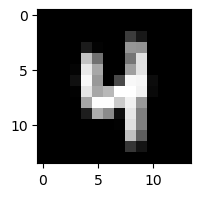

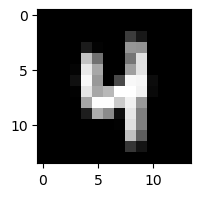

In [4]:
# Create a figure
plt.figure(figsize=(10, 2))


data = np.reshape(next(input_data.training_data[1]),(14,14))
#print(data)
plt.imshow(data, cmap='gray')  # Show in grayscale


plt.show()

plt.figure(figsize=(10, 2))
downsampled_image = downsample_avg(data, m=1)
plt.imshow(downsampled_image, cmap='gray')  # Show in grayscale
plt.show()

In [5]:
################################################
################  Run training #################
################################################

weight_matrix_orig = copy.deepcopy(weight_matrix) # save original rate matrix 

error_list = [] # track errors during training
accuracy_list = [] # track errors during training
accuracy_stride = 10
delE_stride = 100
delE = 0 * 0.02

Wijs_list = []
applied_Wijs_list = []

for training_iter in range(n_training_iters):

    class_number = random.randrange(n_classes) # draw a random class label to present
    # inputs = next(input_data.training_data[class_number]) # get the next data point from the iterator for this class

    try:
        inputs = next(input_data.training_data[class_number])
    except StopIteration:
        input_data.refill_iterators()  # Refill iterators if exhausted
        inputs = next(input_data.training_data[class_number])  # Try again


    ss = weight_matrix.compute_ss_on_inputs(input_inds, inputs) # apply the data as input and get the steady state
    error_list.append(np.linalg.norm(compute_error(ss, input_data, class_number, output_inds))) # save error of this iteration
    
    if (training_iter % accuracy_stride == 0): # compute accuracy for list
        accuracy_list.append(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 50))
        Wijs_list.append(copy.deepcopy(weight_matrix.W_mat))
        applied_Wijs_list.append(weight_matrix.apply_inputs(input_inds,inputs))
        
    nudged_ss = weight_matrix.compute_nudged_ss(input_data, class_number, input_inds, inputs, output_inds, delta_E) # get the steady state after applying a nudge on this input
    ss_frac = nudged_ss / ss # compute pi_nudge / pi
    
    weight_matrix.update(input_inds, inputs, ss_frac, eta) # update the weight_matrix

    if (training_iter & delE_stride == 0):
        weight_matrix.set_W_mat(weight_matrix.Ej_list - delE, weight_matrix.Bij_list, weight_matrix.Fij_list)
    

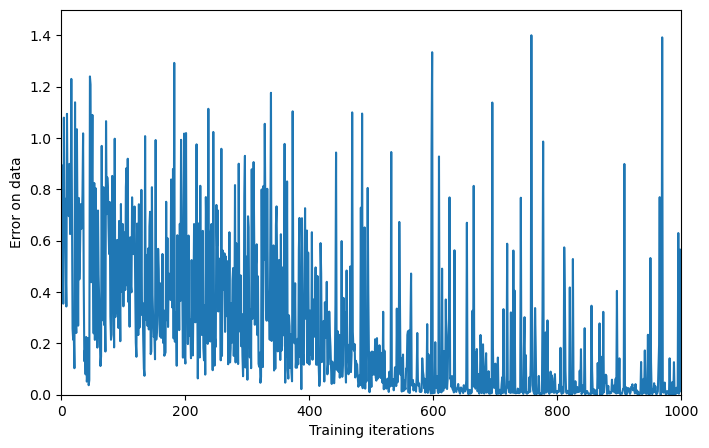

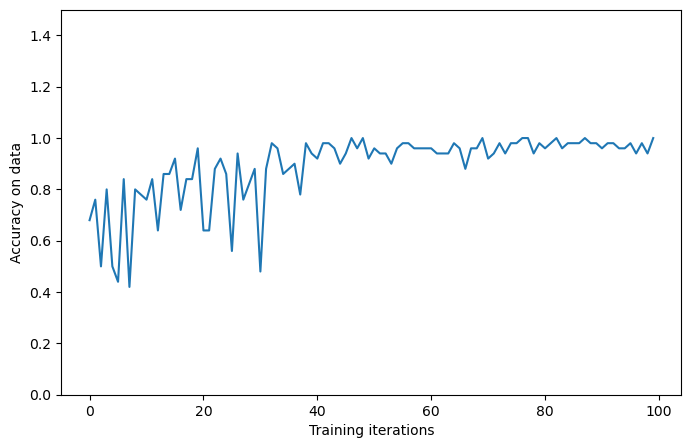

In [6]:
################################################
################  Plot results #################
################################################

### plot the error
plt.figure(figsize=(8, 5))
plt.plot(error_list)
plt.xlabel("Training iterations")
plt.ylabel("Error on data")
plt.ylim(0,1.5)
plt.xlim(0,n_training_iters)
plt.show()


### plot the accuracy
plt.figure(figsize=(8, 5))
plt.plot(accuracy_list)
plt.xlabel("Training iterations")
plt.ylabel("Accuracy on data")
plt.ylim(0,1.5)
#plt.xlim(0,n_training_iters / training_stride)
plt.show()




0.964


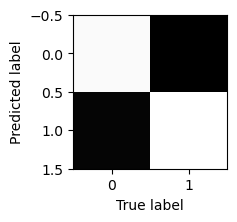

In [7]:

###################################################
################  Get predictions #################
###################################################


print(evaluate_accuracy(weight_matrix, input_inds, input_data, output_inds, n_classes, 500))
predictions_per_class = evaluate_accuracy_per_class(weight_matrix, input_inds, input_data, output_inds, 100, n_classes)

plt.figure(figsize=(10, 2))
plt.imshow(predictions_per_class, cmap='gray')  # Show in grayscale
plt.xlabel("True label")
plt.ylabel("Predicted label")
plt.show()


In [8]:
max_tree_list, max_tree_roots = [], []
min_tree_list, min_tree_roots = [], []

for step_t, wij in enumerate(Wijs_list):
    tree_set_max = get_spanning_trees(n_nodes,wij,1,True)
    max_tree_roots.append(tree_set_max[0])
    max_tree_list.append(tree_set_max[1])

    tree_set_min = get_spanning_trees(n_nodes,wij,1,False)
    min_tree_roots.append(tree_set_min[0])
    min_tree_list.append(tree_set_min[1])

    print('done with',step_t,'steps')
    

done with 0 steps
done with 1 steps
done with 2 steps
done with 3 steps
done with 4 steps
done with 5 steps
done with 6 steps
done with 7 steps
done with 8 steps
done with 9 steps
done with 10 steps
done with 11 steps
done with 12 steps
done with 13 steps
done with 14 steps
done with 15 steps
done with 16 steps
done with 17 steps
done with 18 steps
done with 19 steps
done with 20 steps
done with 21 steps
done with 22 steps
done with 23 steps
done with 24 steps
done with 25 steps
done with 26 steps
done with 27 steps
done with 28 steps
done with 29 steps
done with 30 steps
done with 31 steps
done with 32 steps
done with 33 steps
done with 34 steps
done with 35 steps
done with 36 steps
done with 37 steps
done with 38 steps
done with 39 steps
done with 40 steps
done with 41 steps
done with 42 steps
done with 43 steps
done with 44 steps
done with 45 steps
done with 46 steps
done with 47 steps
done with 48 steps
done with 49 steps
done with 50 steps
done with 51 steps
done with 52 steps
don

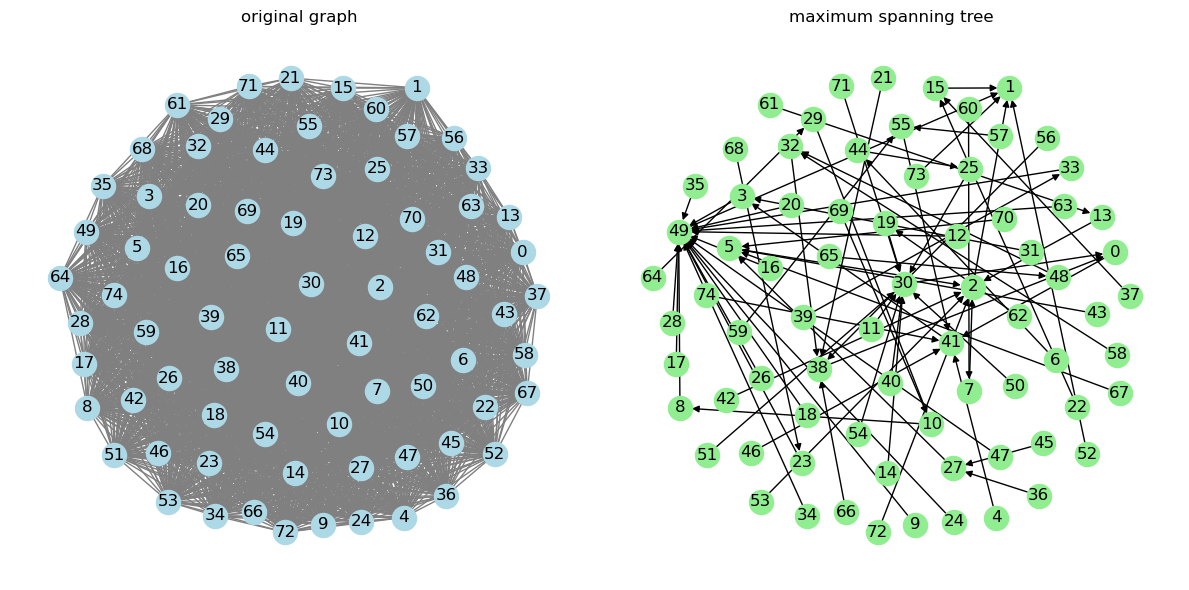

In [11]:
# Get positions for a consistent layout
pos = nx.spring_layout(g, seed=42)

# Plot original graph in light gray
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(g, pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
#edge_labels = nx.get_edge_attributes(dig, 'weight')
#nx.draw_networkx_edge_labels(dig, pos, edge_labels=edge_labels)
plt.title("original graph")

# Plot Maximum Spanning Arborescence in bold
plt.subplot(1, 2, 2)
nx.draw(max_tree_list[-1][0], pos, with_labels=True, node_color='lightgreen', edge_color='black', width=1.0, arrows=True)
#msa_edge_labels = nx.get_edge_attributes(msa, 'weight')
#nx.draw_networkx_edge_labels(msa, pos, edge_labels=msa_edge_labels)
plt.title("maximum spanning tree")

plt.tight_layout()
plt.show()

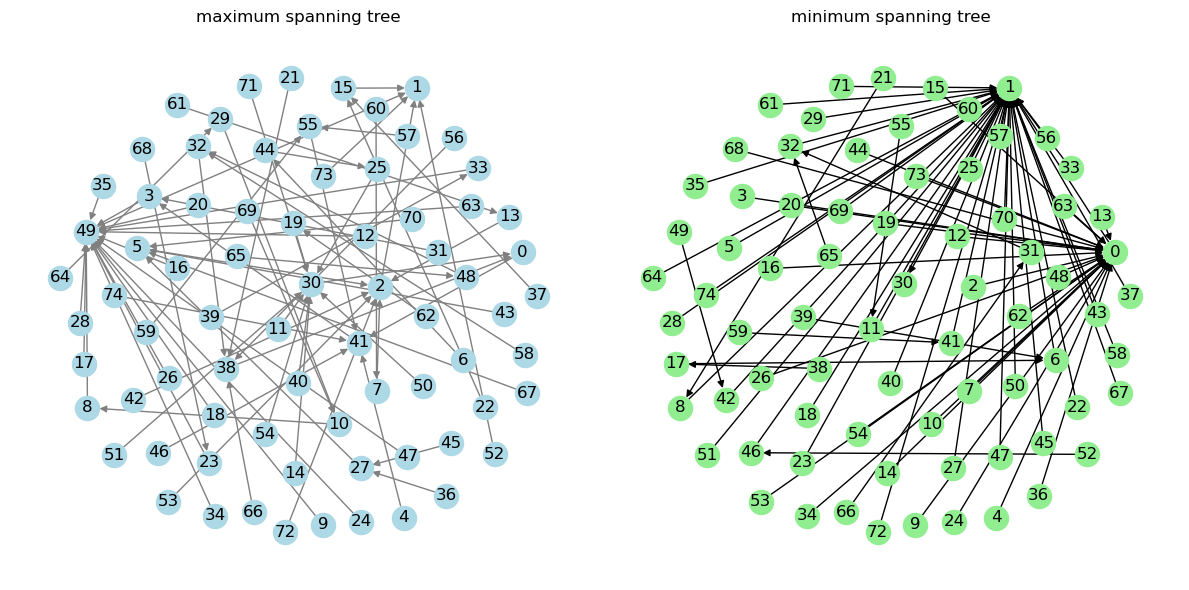

In [12]:
# Plot original graph in light gray
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
nx.draw(max_tree_list[-1][0], pos, with_labels=True, node_color='lightblue', edge_color='gray', arrows=True)
#edge_labels = nx.get_edge_attributes(dig, 'weight')
#nx.draw_networkx_edge_labels(dig, pos, edge_labels=edge_labels)
plt.title("maximum spanning tree")

# Plot Maximum Spanning Arborescence in bold
plt.subplot(1, 2, 2)
nx.draw(min_tree_list[-1][0], pos, with_labels=True, node_color='lightgreen', edge_color='black', width=1.0, arrows=True)
#msa_edge_labels = nx.get_edge_attributes(msa, 'weight')
#nx.draw_networkx_edge_labels(msa, pos, edge_labels=msa_edge_labels)
plt.title("minimum spanning tree")

plt.tight_layout()
plt.show()

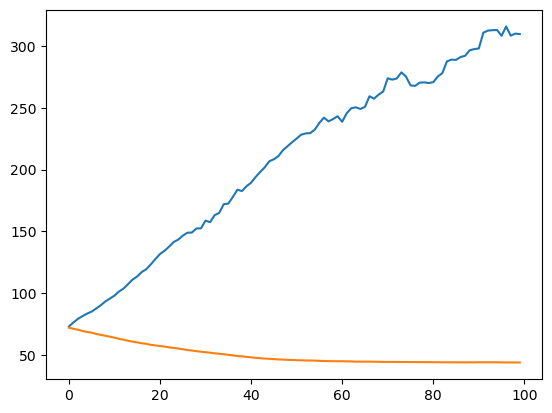

In [28]:
prob_prop_max = [elem[0].size(weight='weight') for elem in max_tree_list] #gets the sum over the weights for max tree at learning step
prob_prop_min = [elem[0].size(weight='weight') for elem in min_tree_list] #gets the sum over the weights for min tree at learning step

plt.plot(range(len(prob_prop_max)), prob_prop_max, prob_prop_min)

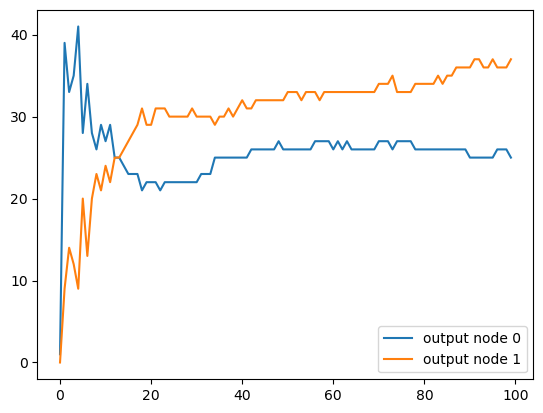

In [39]:
fig, ax = plt.subplots()
for out_idx in output_inds:
    ax.plot(range(len(min_tree_list)), [elem[0].in_degree(out_idx) for elem in min_tree_list], label=r'output node '+str(out_idx))

plt.legend()
plt.show()

In [40]:
nx.hits(min_tree_list[-1][0]);

({0: 2.87438532029862e-06,
  1: -1.977396725673383e-32,
  2: -4.640338067125773e-18,
  3: -5.680024233262171e-18,
  4: -6.437718570559808e-18,
  5: 0.03179650255806387,
  6: 0.000562603614432873,
  7: -6.791515403646703e-18,
  8: 0.036735971677901436,
  9: -5.4840200298470374e-18,
  10: -7.402115491905573e-18,
  11: 0.02201981273154615,
  12: -4.362268937686454e-18,
  13: -7.193868854073238e-18,
  14: -6.743852190066849e-18,
  15: -7.289215994047696e-18,
  16: -7.252590034236384e-18,
  17: -9.241449028503651e-20,
  18: 0.029716670261810615,
  19: -1.0150308612510796e-18,
  20: -5.631994501444256e-18,
  21: 1.0760133554578337e-19,
  22: 0.0057011596051449965,
  23: 0.02851641930417869,
  24: -7.047182762802098e-18,
  25: 0.023162740773831767,
  26: -7.835010424926994e-18,
  27: 0.02829194226705002,
  28: 0.03156841236336261,
  29: 0.03108075515150369,
  30: 0.0,
  31: 3.424763107967332e-20,
  32: 0.008307279201237366,
  33: 0.028992839224103985,
  34: -7.160086233197428e-18,
  35: 0.026

In [11]:
## gets decreasing or increasing spanning trees for a given step; timewise this is more costly than just calculating the max or min tree 
max_trees_list, max_trees_roots = [], []
min_trees_list, min_trees_roots = [], []

N_trees_step = 10

for step_t, wij in enumerate(Wijs_list):
    trees_set_max = get_spanning_trees(n_nodes,wij,N_trees_step,True)
    max_trees_roots.append(trees_set_max[0])
    max_trees_list.append(trees_set_max[1])

    #trees_set_min = get_spanning_trees(n_nodes,wij,N_trees_step,False)
    #min_trees_roots.append(trees_set_min[0])
    #min_trees_list.append(trees_set_min[1])

    print('done with',step_t,'steps')
    
#nx.difference(max_trees_list[-1],max_trees_list[-4]).edges()
#nx.get_edge_attributes(max_trees_list[0], 'weight')

finished with tree 0
finished with tree 1
finished with tree 2
finished with tree 3
finished with tree 4
finished with tree 5
finished with tree 6
finished with tree 7
finished with tree 8
finished with tree 9
done with 0 steps
finished with tree 0
finished with tree 1
finished with tree 2
finished with tree 3
finished with tree 4
finished with tree 5
finished with tree 6
finished with tree 7
finished with tree 8
finished with tree 9
done with 1 steps
319.4928573460056
